In [1]:
import os
import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from egocentric_utils import calculate_extents_from_contours, create_square_bbox, process_images_with_extents, plot_colorline

# Feature extraction
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
import torchvision
import timm

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## FOR FEATURE EXTRACTION
- Try to rotate first and then save to disc > egocentric
- Cut a major square bbox around so that scale is accessible for algorithm

In [ ]:
torch.set_grad_enabled(False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
norm_tf = transforms.Normalize(mean=[0.5],  # maybe adjust this for each network?
                                        std=[0.5])

tfs = transforms.Compose([
    #transforms.Resize(img_size),
    transforms.ToTensor(),
    norm_tf])


root_path = "./data/images/resized_cropped_squarebbox_gs_224/"
ds = torchvision.datasets.ImageFolder(root=root_path)
ds.transform = tfs
print(ds)

dataloader = DataLoader(ds, batch_size=24, num_workers=6, shuffle=False)
model = timm.create_model("vit_base_patch16_224_in21k", pretrained=True, num_classes=0, global_pool="avg").eval()
model.to(device)

# FEATURE Extraction
features = list()
for nth, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    features.append(outputs.detach().cpu().numpy())

# Save feature vectors
feature_vectors = np.concatenate(features)
print(feature_vectors.shape)
del features

In [4]:
# SAVE THE VIT FEATURES FOR IMAGES HERE
SAVE_FEATS = False
if SAVE_FEATS:
    np.save("./data/results/egocentric/feature_vectors.npy", feature_vectors)
else:
    feature_vectors = np.load("./data/results/egocentric/feature_vectors.npy")

/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(-73.54668884277343, 78.0401123046875, -71.45570106506348, 80.13110008239745)

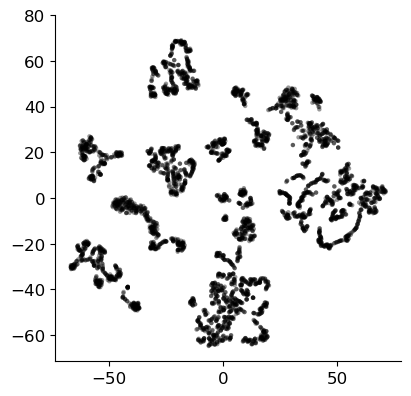

In [5]:
# T-SNE Setup with equal parameters
tsne_params = {"n_components" : 2, "perplexity" : 50, "learning_rate" : 150, "n_iter" : 1000,
               "early_exaggeration" : 50, "random_state" : 42, "init" : "pca", "n_iter_without_progress" : 300}
tsne = TSNE(**tsne_params)
embed = tsne.fit_transform(feature_vectors)  

plt.figure(figsize=(4.5,4.5))
plt.scatter(embed[:, 0], embed[:, 1], alpha=.4, edgecolors="none", s=10, color="k")
plt.axis("square")

[0 1 2 3 4 5 6 7 8 9]


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_27565/201210048.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=6, edgecolors="None", c=colors[nth], alpha=.85)


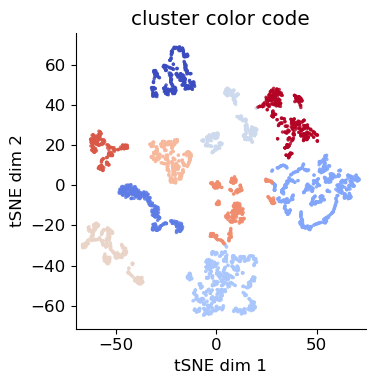

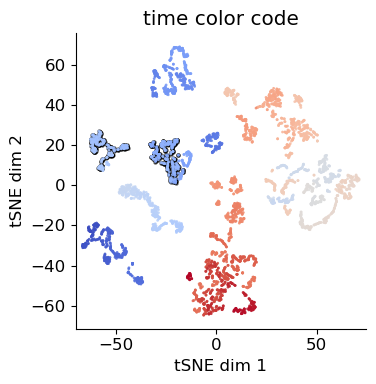

In [6]:
# clustering
time_label = np.arange(0, embed.shape[0], 1)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(embed)
clusters = kmeans.labels_

unique_cluster_labels = np.unique(clusters)
print(unique_cluster_labels)

cmap = plt.get_cmap("coolwarm")
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(unique_cluster_labels))]

plt.figure(figsize=(4,4))
for nth, cluster in enumerate(unique_cluster_labels):
    idx = clusters == cluster
    plt.scatter(embed[idx, 0], embed[idx, 1], marker="o", s=6, edgecolors="None", c=colors[nth], alpha=.85)

plt.title("cluster color code"); plt.axis("equal")
plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()

# Time color code
hindices = np.arange(1000, 1500)  # highlight
tcolors = [cmap(i)[:3] for i in np.linspace(0, 1, len(time_label))]

plt.figure(figsize=(4,4))
plt.scatter(embed[hindices, 0], embed[hindices, 1], marker="o", s=5, edgecolors="k", c="k", alpha=.55)
plt.scatter(embed[:, 0], embed[:, 1], marker="o", s=4, edgecolors="None", c=tcolors, alpha=.85)
plt.title("time color code"); plt.axis("equal"); plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()

In [ ]:
ds.classes

['2024_0201_152845_091_10sec',
 '2024_0201_152845_091_subclip_7sec_ts98-te105_cropped',
 '2024_0216_094236_090_11sec_cropped',
 '2024_0216_161747_055_20sec_cropped',
 '2024_0311_152452_018_trimmed_15sec_ts0-te15_cropped_700-2100-400-1800',
 '2024_0311_153344_021_trimmed_10sec_ts28-te38_cropped_1050-1800-800-2000',
 '2024_0312_200031_053_trimmed_15sec_ts74-te89_cropped_250-1250-0-1100',
 '2024_0330_122058_107_trimmed_ts6-te120']

In [ ]:
labels_ = []
for _, labels in dataloader:
    labels_.append(labels.detach().cpu().numpy())

labels = np.concatenate(labels_)
print(len(labels), np.where(labels==7)[0])

4432 [1875 1876 1877 ... 4429 4430 4431]


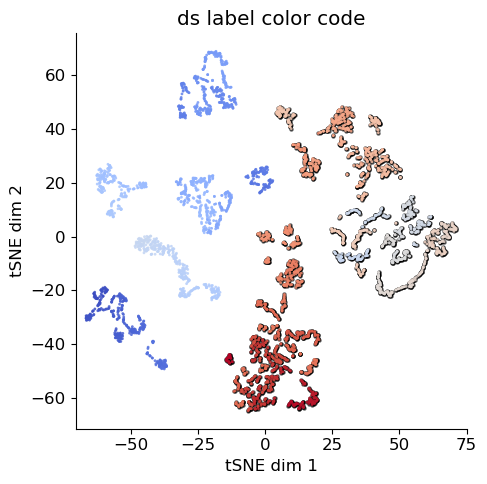

In [ ]:
long_rec_idx = np.where(labels==7)[0]

# Time color code
hindices = np.arange(long_rec_idx[0], long_rec_idx[-1])  # highlight
tcolors = [cmap(i)[:3] for i in np.linspace(0, 1, len(time_label))]

plt.figure(figsize=(5,5))
plt.scatter(embed[hindices, 0], embed[hindices, 1], marker="o", s=5, edgecolors="k", c="k", alpha=.55)
plt.scatter(embed[:, 0], embed[:, 1], marker="o", s=4, edgecolors="None", c=tcolors, alpha=.85)
plt.title("ds label color code"); plt.axis("equal"); plt.xlabel("tSNE dim 1"); plt.ylabel("tSNE dim 2"); plt.tight_layout()

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_27565/733706328.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(time_label[idx], np.ones_like(np.where(idx)[0]) * count * .1, marker="s", s=12, c=colors[nth], alpha=.95) # edgecolors=None,


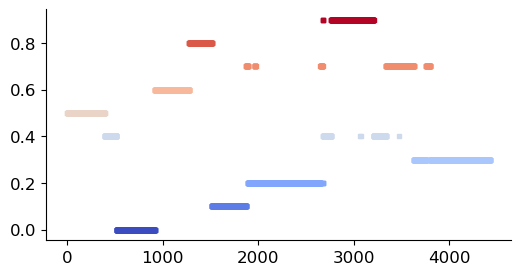

In [7]:
count=0
plt.figure()
for nth, cluster in enumerate(unique_cluster_labels):
    idx = clusters == cluster
    plt.scatter(time_label[idx], np.ones_like(np.where(idx)[0]) * count * .1, marker="s", s=12, c=colors[nth], alpha=.95) # edgecolors=None, 
    count += 1 
# map to image

In [8]:
clusters
cluster_indices = dict()

for nth, cluster in enumerate(unique_cluster_labels):
    idx = np.where(clusters == cluster)[0]
    cluster_indices[nth] = idx

tfs = transforms.Compose([
    transforms.ToTensor()])

ds.transform = tfs

cclust = cluster_indices[0]

for k, v in cluster_indices.items():
    l = list()
    for nth in v:
        l.append(ds.__getitem__(nth)[0])

    slist = torch.stack(l)
    torchvision.utils.save_image(slist, fp=f"./data/results/egocentric/tSNE/resized_gs_224_individual_rotated_cluster_{k}.jpg", nrow=20)